In [6]:
# Jupyter notebook for analysis of LC-21T-FTICRMS data using CoreMS
# Pipeline includes:
# (1) Internal standard qc check, 
# (2) Formula attribution, 
# (3) Feature alignment across samples, 
# (4) Feature filtering, 
# (5) Dispersity Index calculations,
# (6) Heirarchical clustering,
# (7) Cluster analysis. 
# (8) BATS metadata plotter.

# Developed for data collected on DOM isolated from the Bermuda Atlantic Time Series using CoreMS
# RMB update 1/12/2023
# Contributors: Yuri Corilo, Will Kew, Christian Dewey, Rene Boiteau

##########

# Import required modules
import os
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("./")
from pathlib import Path

# Change the current working directory to the parent folder
os.chdir('../..')

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data'
files=os.listdir('/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data')

# Import other required modules
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import ranksums

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration


## This points to the reference mass list used for calibration. 
refmasslist = Path.cwd() / "tests/tests_data/ftms/Seawater_NOM_pos.ref"

#Set peak detection threshold method and search criteria
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001
MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25
MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20
MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)
MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False
MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

#Read in sample list and load MS data
samplelist=pd.read_csv(file_location+'/'+'BATS_samplelist.csv')
MSfiles={}
for file in samplelist['File'][samplelist['Sample type']=='sample']:
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
    MSfiles[file]=parser

samplelist=samplelist[samplelist['File'].isin(MSfiles.keys())]

19 pass of 20
11.1 % std dev


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


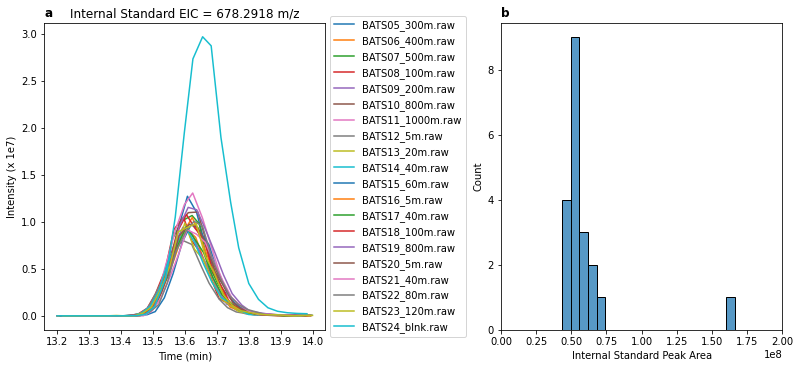

In [2]:
### (1) Internal standard QC Check
### Module compares internal standard peak area across samples. Outliers are flagged.

stdmass=678.2918 # m/z of cycanocobalamin
std_timerange=[13.2,14] # retention time range of peak (min)

# Plot standard EIC over time range and integrate peak area. 
area=[]
rt=[]

fig, axs = plt.subplot_mosaic([['a','b']], figsize=(11,5), constrained_layout=True)
axs['a'].set(xlabel='Time (min)',ylabel='Intensity',title='Internal Standard EIC = '+str(stdmass) + ' m/z')

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    axs['a'].plot(df_sub['time'],df_sub['EIC']/1e7,label=file[11:])
axs['a'].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs['a'].set_title('a', fontweight='bold', loc='left')
axs['a'].set_ylabel('Intensity (x 1e7)')

samplelist['qc_area']=area
samplelist['qc_rt']=rt


# Flag outliers with peak area greater than 2x standard deviation of the mean 

peak_stdv=samplelist[samplelist['Sample type']=='sample'].qc_area.std()
peak_mean=samplelist[samplelist['Sample type']=='sample'].qc_area.mean()

samplelist['qc_pass']=0
for i in samplelist.index:
    if (abs(samplelist.qc_area[i]-peak_mean)<2*peak_stdv):
        samplelist.qc_pass[i]=1

print(str(samplelist[samplelist['Sample type']=='sample'].qc_pass.sum()) + ' pass of ' + str(len(samplelist[samplelist['Sample type']=='sample'])))

peak_stdv=samplelist[samplelist.qc_pass==1].qc_area.std()

print(str(round(peak_stdv/peak_mean*100,1))+' % std dev')

#Create plot of overlaid standard EICs
sns.histplot(x='qc_area',data=samplelist,ax=axs['b'])
axs['b'].set_xlabel('Internal Standard Peak Area')
axs['b'].set_xlim(0,20e7)
axs['b'].set_title('b', fontweight='bold', loc='left')

plt.savefig(file_location+'CoreLCMS_FigS5.eps',dpi=300,format='eps')
plt.savefig(file_location+'CoreLCMS_FigS5.pdf',dpi=300,format='pdf')

plt.show()

In [7]:
### (2) Formula attribution
### Module defines the function to build list of molecular formula assigned features. 

#Define time range and bin size (interval) for mass spectrum averaging. 
timerange=[4,26]
interval=2

#Define ICRMS parameters needed for resolution calculations. 
B=21 #magnetic field strength
T=0.6 #transient time

def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        #Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)

        #This filters based on resolving power to remove noise. Assumes ICR-MS. 
        mass_spectrum.filter_by_min_resolving_power(B, T)
    
        mass_spectrum.settings.min_calib_ppm_error = 2
        mass_spectrum.settings.max_calib_ppm_error = -2
        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()
        calfn = MzDomainCalibration(mass_spectrum, refmasslist)
        ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

        imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=(-2.0, 2.0),
                                                    calib_snr_threshold=3)

        calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
        #results(timestart)=assignments[assignments['Calculated m/z']>1].filter(['m/z','corr','Peak Height','Confidence Score','Molecular Formula','Time']))
    
    results=pd.concat(results,ignore_index=True)

    return(results)

In [14]:
### (2) Run Formula Attribution
### Module runs the LCMS batch formula assignment function.

masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#Create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
masterresults_df.to_csv(file_location+'masterresults_5.csv')

RMB_190828_BATS05_300m.raw
MS Obj loaded - 332 peaks found.
MS Obj loaded - 332 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
187 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 366 fn evals and 7 iterations


KeyboardInterrupt: 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0     0.178803
1     0.114894
2     0.073321
3     0.042446
4     0.033564
5     0.037355
6     0.036212
7     0.047141
8     0.060569
9     0.092721
10    0.204483
dtype: float64
All Unique results: 13273


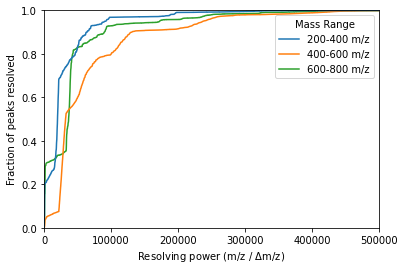

In [11]:
### (3) Feature alignment across samples, 
### Module generates plots showing fraction of peaks resolved versus resolving power.

#Load masterresults_df
masterresults_df=pd.read_csv(file_location+'masterresults_5.csv')

#Note, this line filters masterresults to only contain samples.
masterresults_df=masterresults_df[masterresults_df.File.isin(samplelist.File[samplelist['Sample type']=='sample'])]

#Calculate required resolving power
res_summary=[]
mzinterval=200
mzint=range(200,800,mzinterval)
for time in masterresults_df['Time'].unique():
    
    result=masterresults_df[masterresults_df['Time']==time]

    for file in masterresults_df['File'].unique():

        result_sub=result[result['File']==file]

        for mz in mzint:
            result_sub_mz=result_sub[(result_sub['m/z']>mz) & (result_sub['m/z'] < mz + mzinterval)]
            mzvalues=result_sub_mz['m/z'].sort_values(ascending=True)
            differences=mzvalues.diff()
            #Resolve from peaks on either side
            mzdiff=pd.DataFrame({'left':differences[1:-1].to_list(),'right':differences[2:].to_list()})
            mzdiff=mzdiff.min(axis=1)
            mzvalues=mzvalues.iloc[1:-1].reset_index()['m/z']
            #mzdiff_res=mzvalues/mzdiff*2
            mzdiff_res=mzvalues/mzdiff*2
            for i in mzdiff_res.index:
                res_summary.append({'resolution':mzdiff_res[i],'mass':mzvalues[i],'Mass Range':str(mz)+'-'+str(mz+mzinterval) + ' m/z','file':file,'time':time})

res_summary_df=pd.DataFrame(res_summary)
fig, (ax) = plt.subplots(1)
sns.ecdfplot(x='resolution',hue='Mass Range',data=res_summary_df,ax=ax)
ax.set_xlim(0,500000)
ax.set_xlabel('Resolving power (m/z / '+r'$\Delta$'+'m/z)')
ax.set_ylabel('Fraction of peaks resolved')

fig.savefig(file_location+'CoreLCMS_FigS2.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS2.pdf',dpi=300,format='pdf')

#Generate 'results' data frame that describes molecular stoichiometries and molecular classes. 
allresults=masterresults_df[(masterresults_df['m/z']<800)]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)
allresults['Peak Height']=allresults['Peak Height'].fillna(0)

allresults['mol_class']='Unassigned'
allresults['mol_class'][allresults['C']>0]='CHO'
allresults['mol_class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'

results= allresults[allresults['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

# Calculate Nominal Oxidation State of Carbon (NOSC)
results['NOSC'] =  4 -(4*results['C'] + results['H'] - 3*results['N'] - 2*results['O'])/results['C']


#Calculate and print the fraction of unassigned features within each time bin.
assign_summary=[]
for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
df=pd.DataFrame(assign_summary)

calc=pd.DataFrame(assign_summary)
fraction_Assigned=calc.Unassigned/(calc.CHO+calc.CHON+calc.Unassigned)
print(fraction_Assigned)
 

#Create a list of all unique features and their abundances across samples.
uniquelist=[]
for time in results.Time.unique():
    current=results[results.Time==time]
    current=current.sort_values(by=['Peak Height'],ascending=False)
    currentunique=current.drop_duplicates(subset=['Molecular Formula'])
    currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
    for file in results['File'].unique():
        current_file=current[current['File']==file]
        current_file=current_file.rename(columns={'Peak Height':file})
        current_file=current_file.set_index(['Molecular Formula'],drop=False)
        currentunique=currentunique.join(current_file[file])
    uniquelist.append(currentunique)

uniqueresults=pd.concat(uniquelist,ignore_index=True)
print("All Unique results: " + str(len(uniqueresults)))



Unique results, S/N>3: 10074
Unique results, blank subtracted: 9162
Unique results, min thresh: 8379
Unique molecular formula: 2165


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


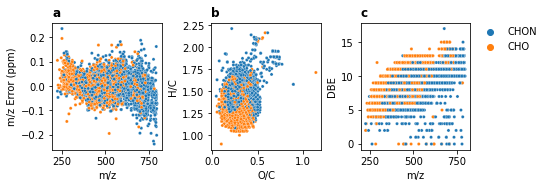

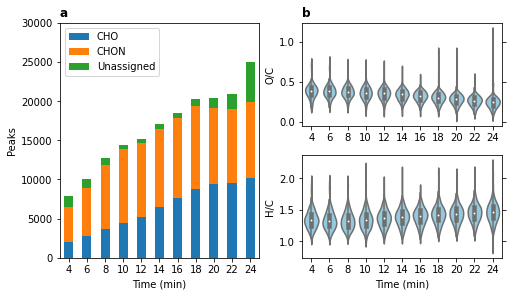

In [12]:
### (4) Feature filtering (abundance, blank subtraction, minimum samples) and metric plots

#remove low abundance hits
uniqueresults=uniqueresults[uniqueresults["S/N"]>3]
print("Unique results, S/N>3: " + str(len(uniqueresults)))

#remove features detected in the blank within 50% of the max intensity. 
uniqueresults['blank']=uniqueresults['RMB_190828_BATS24_blnk.raw'].fillna(0)/uniqueresults['Peak Height']
uniqueresults=uniqueresults[uniqueresults['blank']<0.5]
print("Unique results, blank subtracted: " + str(len(uniqueresults)))

#remove hits that don't appear in a minimum of 5 samples:
uniqueresults['occurrence']=uniqueresults[results['File'].unique()].gt(0).sum(axis=1)
uniqueresults=uniqueresults[uniqueresults['occurrence']>4.5]

print("Unique results, min thresh: " + str(len(uniqueresults)))
print("Unique molecular formula: " + str(len(uniqueresults['Molecular Formula'].unique())))

#Generate plot of m/z error and molecular stoichiometry for all features (Fig S4)

fig, axs = plt.subplot_mosaic([['a','b','c']], figsize=(7.5,2.5), constrained_layout=True)

sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='mol_class',data=uniqueresults,ax=axs['a'],s=10, legend=False)
#axs['a'].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs['a'].set_title('a', fontweight='bold', loc='left')

sns.scatterplot(x='O/C',y='H/C',hue='mol_class',data=uniqueresults,ax=axs['b'],s=10, legend=False)
#axs['a'].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs['b'].set_title('b', fontweight='bold', loc='left')

sns.scatterplot(x='m/z',y='DBE',hue='mol_class',data=uniqueresults,ax=axs['c'],s=10)
axs['c'].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
axs['c'].set_title('c', fontweight='bold', loc='left')


fig.savefig(file_location+'CoreLCMS_FigS4.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS4.pdf',dpi=300,format='pdf')


#Generate bar plot of formula assigned peaks and molecular stoichiometries over time (Fig 2)
fig, axs = plt.subplot_mosaic([['a','b'],['a','c']], figsize=(7,4), constrained_layout=True)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=axs['a'])
axs['a'].set_xticklabels(axs['a'].get_xticklabels(),rotation=0)
axs['a'].set_title('a', fontweight='bold', loc='left')
axs['a'].set_ylim(0,30000)
axs['a'].set(xlabel='Time (min)')

sns.violinplot(x="Time", y="O/C", data=uniqueresults, ax=axs['b'], legend=False, color='skyblue')
axs['b'].set(xlabel=None)
axs['b'].tick_params(right=True)
axs['b'].set_title('b', fontweight='bold', loc='left')

sns.violinplot(x="Time", y="H/C", data=uniqueresults, ax=axs['c'], legend=False, color='skyblue')
axs['c'].set(xlabel='Time (min)')
axs['c'].tick_params(right=True)
#axs['c'].set_title('c', fontweight='bold', loc='left')
axs['c'].sharex(axs['b'])

fig.savefig(file_location+'CoreLCMS_Fig2.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_Fig2.pdf',dpi=300,format='pdf')

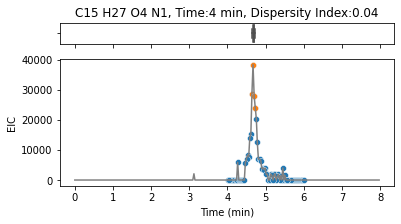

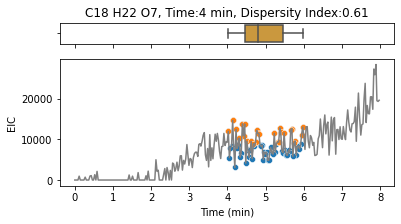

In [13]:
### (5) Dispersity Index calcuations
# Module calculates Dispersity index based on extracted ion chromatograms of each feature

#Calculate Dispersity Index. 
EIC={}
for file in uniqueresults['File'].unique():
    masses=uniqueresults[uniqueresults['File']==file]['m/z'].unique().tolist()
    EIC[file]=MSfiles[file].get_eics(target_mzs=masses,tic_data={},peak_detection=False,smooth=False)
    
dispersity=[]
for ind in uniqueresults.index:
    current=uniqueresults.loc[ind]
    time=[0,2]+current.Time
    file=current.File
    mass=current['m/z']
    chroma=pd.DataFrame({'EIC':EIC[file][0][mass].eic,'time':EIC[file][0][mass].time})
    chroma=chroma[chroma['time'].between(time[0],time[1])]
    chroma=chroma.sort_values(by='EIC',ascending=False)
    d=chroma[chroma.cumsum()['EIC']<0.5*chroma.sum()['EIC']].time.std()
    dispersity.append(d)

uniqueresults['Dispersity']=dispersity


#Define function that plots EIC of a feature and subset of peaks used for dispersity index calculation.
def dispersity_plotter(x):
    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,gridspec_kw=dict(height_ratios=[0.5,3]))
    fig.set_size_inches(6,3)    
    current=uniqueresults.loc[x]
    time=[0,2]+current.Time
    file=current.File
    mass=current['m/z']
    chroma=pd.DataFrame({'EIC':EIC[file][0][mass].eic,'time':EIC[file][0][mass].time})
    chrom_all=chroma[chroma['time'].between(0,8)]
    chroma=chroma[chroma['time'].between(time[0],time[1])]
    chroma=chroma.sort_values(by='EIC',ascending=False)
    chroma2=chroma[chroma.cumsum()['EIC']<0.5*chroma.sum()['EIC']]
    d=chroma[chroma.cumsum()['EIC']<0.5*chroma.sum()['EIC']].time.std()
    sns.boxplot(x='time',data=chroma2,ax=ax1,color='#E19E27')
    ax1.set_xlabel(None)
    ax1.set_title(current['Molecular Formula']+', Time:' + str(current['Time']) + ' min, Dispersity Index:' + str(current['Dispersity'].round(2)))
    sns.lineplot(x='time',y='EIC',data=chrom_all,ax=ax2,color='gray')
    sns.scatterplot(x='time',y='EIC',data=chroma,ax=ax2)
    sns.scatterplot(x='time',y='EIC',data=chroma2,ax=ax2)
    ax2.set_xlabel('Time (min)')
    fig.savefig(file_location+'CoreLCMS_FigS8_'+current['Molecular Formula']+'.eps',dpi=300,format='eps')
    fig.savefig(file_location+'CoreLCMS_FigS8_'+current['Molecular Formula']+'.pdf',dpi=300,format='pdf')

#Plot examples of dispersity index calculations (Fig S8) for selected illustrative features
dispersity_plotter(230)
dispersity_plotter(57)


8379


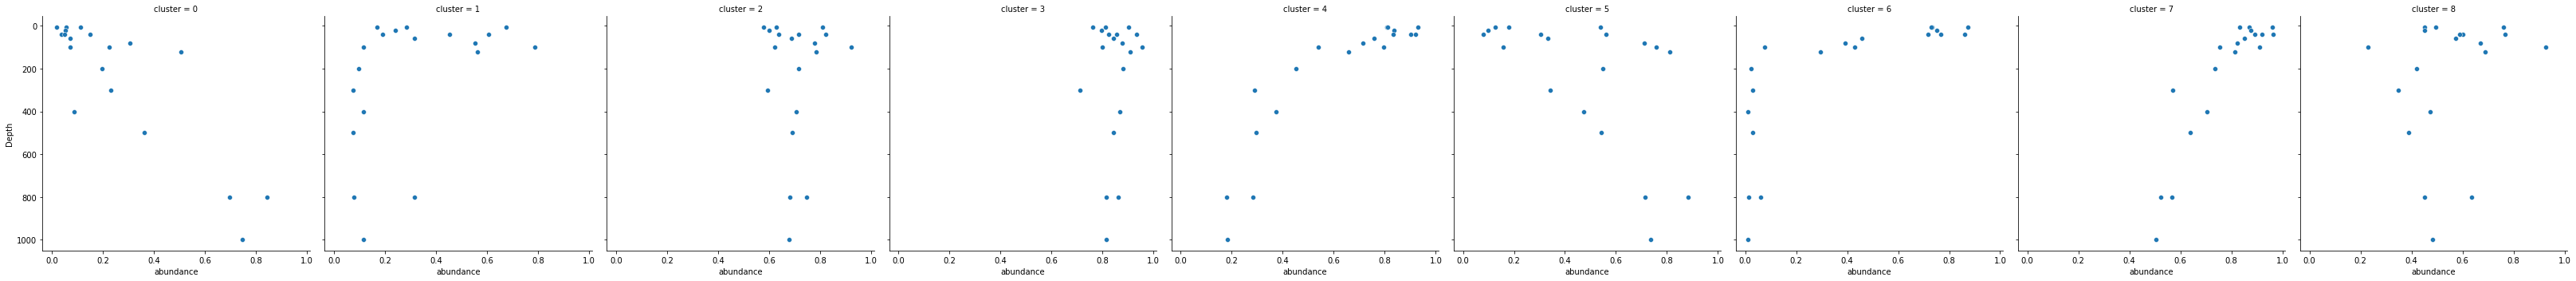

In [14]:
### (6) Hierarchical Clustering
### Generate clusters of ms features across depth.

#Cluster settings
clustermethod='ward'
nclusters=9

#Clustering functions

results_clustered=uniqueresults

norm_abundances=results_clustered[masterresults_df['File'].unique()].fillna(0)
norm_abundances=norm_abundances.div(norm_abundances.max(axis=1),axis=0)


cluster = AgglomerativeClustering(n_clusters=nclusters,affinity='euclidean',linkage=clustermethod)
cluster.fit_predict(norm_abundances)

results_clustered['cluster']=cluster.labels_
print(len(results_clustered))
samplelist['Depth']=samplelist['Depth (m)']

depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

clustered_results=[]
for i in results_clustered['cluster'].unique():
    current=pd.DataFrame({'abundance':norm_abundances[results_clustered['cluster']==i].sum(axis=0)/len(results_clustered[results_clustered['cluster']==i]),'Depth':depth,'cluster':i})
    clustered_results.append(current)

clustered_results=pd.concat(clustered_results)
clustered_results=clustered_results.sort_values(by='Depth',ascending=True)

g = sns.relplot(data=clustered_results, col='cluster', x='abundance', y='Depth', kind='scatter')
for ax in g.axes[0]:
    ax.invert_yaxis()

plt.show()

results_clustered['NOSC'] =  4 -(4*results_clustered['C'] + results_clustered['H'] - 3*results_clustered['N'] - 2*results_clustered['O'])/results_clustered['C']
results_clustered=results_clustered.sort_values(by='cluster')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(0.0, 1.0, 'f')

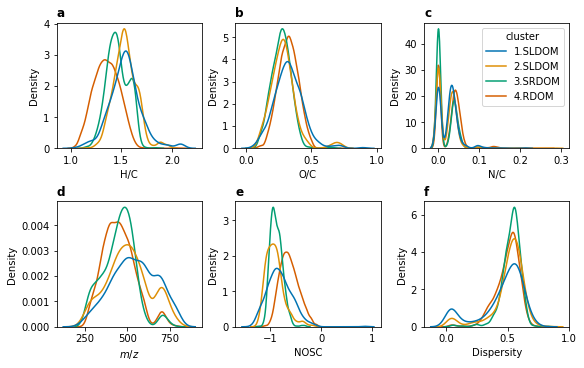

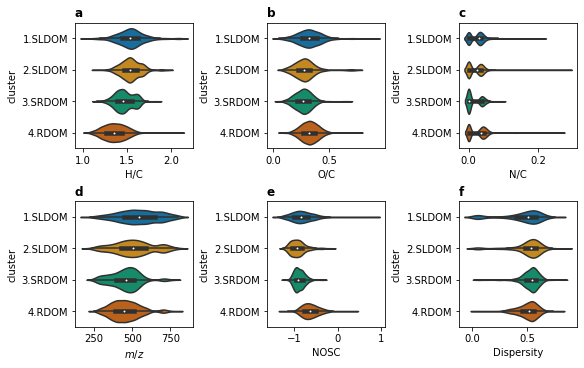

In [15]:
### (6) Hierarchical Clustering
### Module defines clusters based on depth distribution and plots density distribution of properties of each cluster:

#Define clusters
results_clustered.cluster[results_clustered.cluster==0]='out'
results_clustered.cluster[results_clustered.cluster==1]='1.SLDOM'
results_clustered.cluster[results_clustered.cluster==2]='4.RDOM'
results_clustered.cluster[results_clustered.cluster==3]='4.RDOM'
results_clustered.cluster[results_clustered.cluster==4]='2.SLDOM'
results_clustered.cluster[results_clustered.cluster==5]='out'
results_clustered.cluster[results_clustered.cluster==6]='1.SLDOM'
results_clustered.cluster[results_clustered.cluster==7]='3.SRDOM'
results_clustered.cluster[results_clustered.cluster==8]='out'
results_clustered.cluster[results_clustered.cluster==8]='3.SRDOM'

# Save clustered results (Table S1)
results_clustered.to_csv(file_location+'TableS1_clustered_results.csv')

# Discard out cluster
results_clustered=results_clustered[results_clustered.cluster!='out']
results_clustered=results_clustered.sort_values(by='cluster')

# Generate figures (Fig. 4)
sns.set_palette("colorblind",5)

fig2, axs = plt.subplot_mosaic([['a','b','c'],['d','e','f']], figsize=(8,5), constrained_layout=True)
sns.kdeplot(x='H/C',hue='cluster', data=results_clustered, ax=axs['a'], common_norm=False,legend=False)
axs['a'].set_title('a', fontweight='bold', loc='left')
sns.kdeplot(x='O/C',hue='cluster', data=results_clustered, ax=axs['b'], common_norm=False,legend=False)
axs['b'].set_title('b', fontweight='bold', loc='left')
sns.kdeplot(x='N/C',hue='cluster', data=results_clustered, ax=axs['c'], common_norm=False,legend=True)
axs['c'].set_title('c', fontweight='bold', loc='left')
sns.kdeplot(x='m/z',hue='cluster', data=results_clustered, ax=axs['d'], common_norm=False,legend=False)
axs['d'].set_title('d', fontweight='bold', loc='left')
axs['d'].set_xlabel("$\it{m/z}$")
sns.kdeplot(x='NOSC',hue='cluster', data=results_clustered, ax=axs['e'], common_norm=False,legend=False)
axs['e'].set_title('e', fontweight='bold', loc='left')
sns.kdeplot(x='Dispersity',hue='cluster', data=results_clustered, ax=axs['f'], common_norm=False,legend=False)
axs['f'].set_title('f', fontweight='bold', loc='left')

fig2.savefig(file_location+'CoreLCMS_Fig4.eps',dpi=300,format='eps')
fig2.savefig(file_location+'CoreLCMS_Fig4.pdf',dpi=300,format='pdf')

# Generate violin plots version
fig2, axs = plt.subplot_mosaic([['a','b','c'],['d','e','f']], figsize=(8,5), constrained_layout=True)
sns.violinplot(x='H/C',y='cluster', data=results_clustered, ax=axs['a'], common_norm=False,legend=False)
axs['a'].set_title('a', fontweight='bold', loc='left')
sns.violinplot(x='O/C',y='cluster', data=results_clustered, ax=axs['b'], common_norm=False,legend=False)
axs['b'].set_title('b', fontweight='bold', loc='left')
sns.violinplot(x='N/C',y='cluster', data=results_clustered, ax=axs['c'], common_norm=False,legend=False)
axs['c'].set_title('c', fontweight='bold', loc='left')
sns.violinplot(x='m/z',y='cluster', data=results_clustered, ax=axs['d'], common_norm=False,legend=False)
axs['d'].set_title('d', fontweight='bold', loc='left')
axs['d'].set_xlabel("$\it{m/z}$")
sns.violinplot(x='NOSC',y='cluster', data=results_clustered, ax=axs['e'], common_norm=False,legend=False)
axs['e'].set_title('e', fontweight='bold', loc='left')
sns.violinplot(x='Dispersity',y='cluster', data=results_clustered, ax=axs['f'], common_norm=False,legend=False)
axs['f'].set_title('f', fontweight='bold', loc='left')


6740
930
840
768
4202
39
130
49
6
39
RanksumsResult(statistic=-31.50024462411068, pvalue=8.619720423816056e-218)
RanksumsResult(statistic=0.459666824814269, pvalue=0.645755385501831)
RanksumsResult(statistic=6.243774072850302, pvalue=4.2713683964981104e-10)
RanksumsResult(statistic=-20.189043403647116, pvalue=1.2220767384612507e-90)
RanksumsResult(statistic=22.590789416686174, pvalue=5.338521220269976e-113)
RanksumsResult(statistic=2.2078731800441243, pvalue=0.027253114916747933)


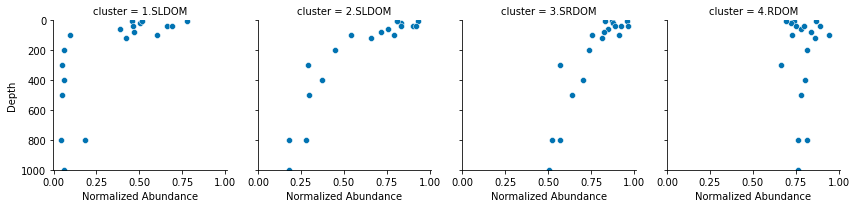

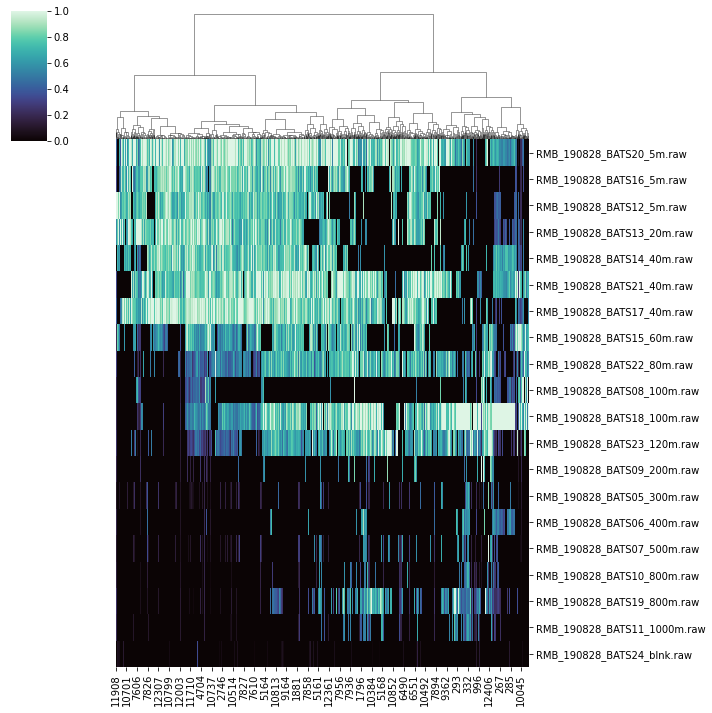

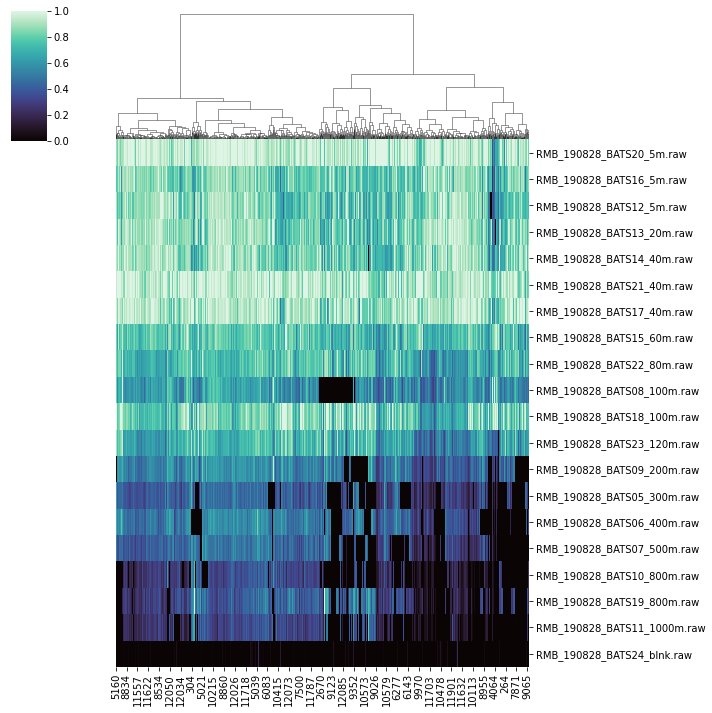

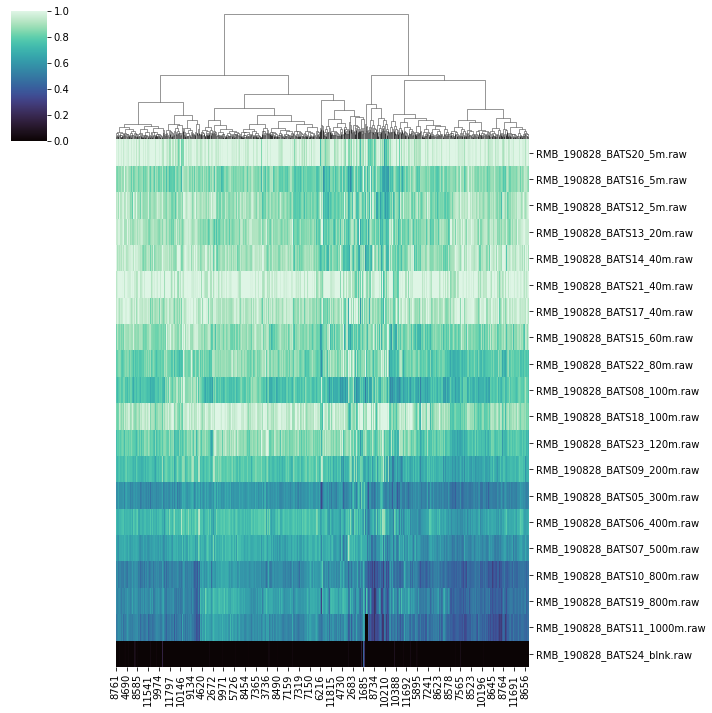

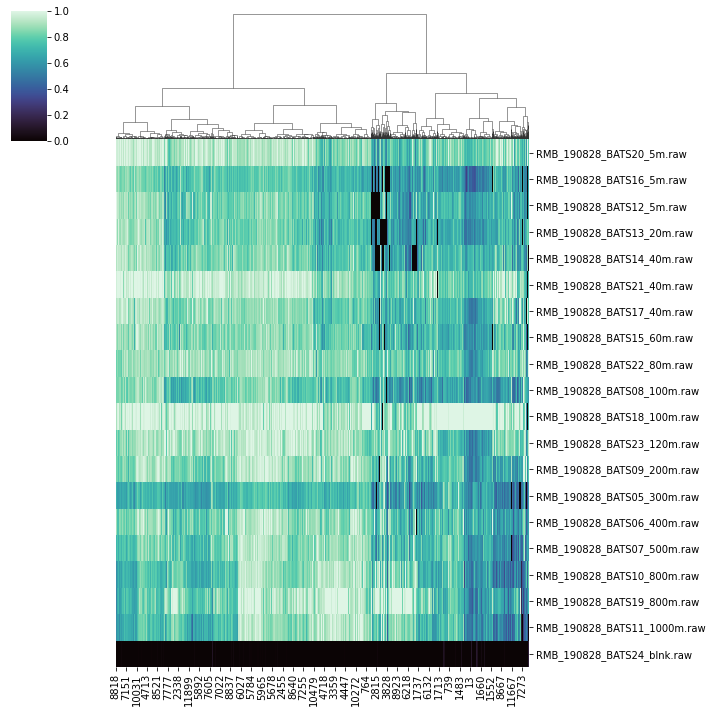

In [16]:
### (7) Cluster analysis
### Module determines and plots the mean depth distribution of each cluster

norm_abundances=results_clustered[masterresults_df['File'].unique()].fillna(0)
norm_abundances=norm_abundances.div(norm_abundances.max(axis=1),axis=0)

depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

clustered_results=[]
for i in results_clustered['cluster'].unique():
    current=pd.DataFrame({'abundance':norm_abundances[results_clustered['cluster']==i].sum(axis=0)/len(results_clustered[results_clustered['cluster']==i]),'Depth':depth,'cluster':i})
    clustered_results.append(current)

clustered_results=pd.concat(clustered_results)

h = sns.relplot(data=clustered_results, col='cluster', x='abundance', y='Depth', kind='scatter', height=3)
for ax in h.axes[0]:
    ax.set_ylim(1000,0)
    ax.set_xlabel('Normalized Abundance')

h.savefig(file_location+'CoreLCMS_FigS6.eps',dpi=300,format='eps')
h.savefig(file_location+'CoreLCMS_FigS6.pdf',dpi=300,format='pdf')

#Print number of features in each cluster
print(len(results_clustered))
print(len(results_clustered[results_clustered.cluster=='1.SLDOM']))
print(len(results_clustered[results_clustered.cluster=='2.SLDOM']))
print(len(results_clustered[results_clustered.cluster=='3.SRDOM']))
print(len(results_clustered[results_clustered.cluster=='4.RDOM']))
#Print number of discrete (dispersity <0.2) features in each cluster
print(len(results_clustered[(results_clustered.cluster=='4.RDOM') & (results_clustered.Dispersity<0.2)]))
print(len(results_clustered[(results_clustered.cluster=='1.SLDOM') & (results_clustered.Dispersity<0.2)]))
print(len(results_clustered[(results_clustered.cluster=='2.SLDOM') & (results_clustered.Dispersity<0.2)]))
print(len(results_clustered[(results_clustered.cluster=='3.SRDOM') & (results_clustered.Dispersity<0.2)]))
print(len(results_clustered[(results_clustered.cluster=='4.RDOM') & (results_clustered.Dispersity<0.2)]))

#Create and saves heatmap for each cluster (Fig. 5)

for cluster in results_clustered['cluster'].unique():
    current=results_clustered[results_clustered['cluster']==cluster]
    current=current[masterresults_df['File'].unique()].fillna(0)
    current=current.div(current.max(axis=1),axis=0)
    clusterplot=norm_abundances
    current=current.transpose()
    current['Depth']=depth
    current=current.sort_values(by='Depth')
    current=current.drop(['Depth'],axis=1)
    h=sns.clustermap(current,row_cluster=False,cmap='mako',method=clustermethod)
    h.savefig(file_location+'CoreLCMS_Fig3'+cluster+'.eps',dpi=300,format='eps')

### Performs statistical tests to determine significant compositional differences between across clusters. 

print(ranksums(results_clustered[results_clustered['cluster']=='4.RDOM']['H/C'],results_clustered[results_clustered['cluster']=='1.SLDOM']['H/C']))
print(ranksums(results_clustered[results_clustered['cluster']=='4.RDOM']['O/C'],results_clustered[results_clustered['cluster']=='1.SLDOM']['O/C']))
print(ranksums(results_clustered[results_clustered['cluster']=='4.RDOM']['N/C'],results_clustered[results_clustered['cluster']=='1.SLDOM']['N/C']))
print(ranksums(results_clustered[results_clustered['cluster']=='4.RDOM']['m/z'],results_clustered[results_clustered['cluster']=='1.SLDOM']['m/z']))
print(ranksums(results_clustered[results_clustered['cluster']=='4.RDOM']['NOSC'],results_clustered[results_clustered['cluster']=='1.SLDOM']['NOSC']))
print(ranksums(results_clustered[results_clustered['cluster']=='4.RDOM']['Dispersity'],results_clustered[results_clustered['cluster']=='1.SLDOM']['Dispersity']))

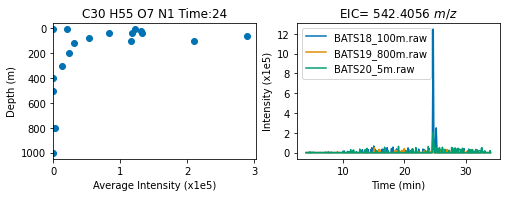

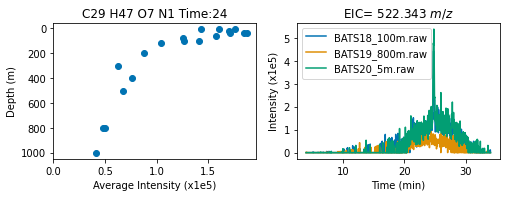

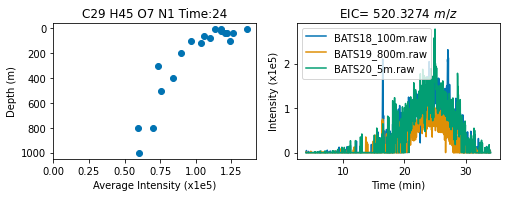

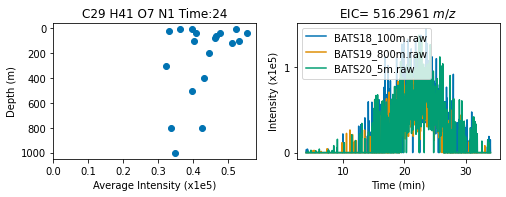

In [17]:
### (7) Cluster analysis
### Module plots examples of individual feature profiles and EICs

matplotlib.rcParams['pdf.fonttype'] = '42'
import matplotlib.ticker as ticker

def profile_eic_plot(mf,time):
    result=results_clustered[(results_clustered['Molecular Formula']==mf) & (results_clustered['Time']==time)].squeeze()
    intensity=result[samplelist['File'].unique()].fillna(0)/1e5
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(8,2.5)
    ax1.scatter(x=intensity,y=depth)
    ax1.set(xlabel='Average Intensity (x1e5)')
    ax1.set(xlim=[0,max(intensity)*1.05])
    ax1.set(ylabel='Depth (m)')
    ax1.set(title=result['Molecular Formula']+' Time:' + str(result['Time']))
    #ax1.axes.get_xaxis().set_major_locator(MaxNLocator(integer=True))
    ax1.invert_yaxis()

    stdmass=result['m/z']
    std_timerange=[4,34]

    area=[]
    rt=[]
    ax2.set(xlabel='Time (min)',ylabel='Intensity (x1e5)',title='EIC= '+str(stdmass.round(4))+' $\it{m/z}$')
    ax2.axes.get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))
    files=['RMB_190828_BATS18_100m.raw', 'RMB_190828_BATS19_800m.raw', 'RMB_190828_BATS20_5m.raw']
    for file in files:

        EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
        df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
        df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
        area.append(sum(df_sub['EIC']))
        rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
        ax2.plot(df_sub['time'],df_sub['EIC']/1e5,label=file[11:])

    ax2.legend(loc='upper left')
    fig.savefig(file_location+'CoreLCMS_Fig5'+mf+'.pdf',dpi=300,format='pdf')
    
profile_eic_plot('C30 H55 O7 N1',24)
profile_eic_plot('C29 H47 O7 N1',24)
profile_eic_plot('C29 H45 O7 N1',24)
profile_eic_plot('C29 H41 O7 N1',24)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


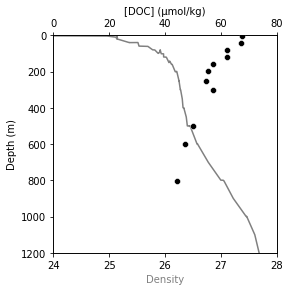

In [18]:
### (8) BATS metadata plotter
### Module generates and save plot of BATS DOM and density data

DOC_data=pd.read_csv(file_location+'/BATS_CTD_DOM_data.csv')
Hydro_data=pd.read_csv(file_location+'/B360_Hydrodata.csv')
fig, ax1 = plt.subplots()
fig.set_size_inches(4,4)

ax1.set_ylabel('Depth (m)')
ax1.set_ylim(1200,0)

ax1.set_xlabel('Density')
ax1.set_xlim(24,28)
sns.lineplot(x='sig_theta(kg/m^3)', y='Depth', data=Hydro_data, ax=ax1,color='gray')
ax1.xaxis.label.set_color('gray')        #setting up X-axis label color to gray
#sns.lineplot(x='CTD_S', y='Depth', data=DOC_data, ax=ax1)
#sns.lineplot(x='sig_theta(kg/m^3)', y='Depth', data=DOC_data, ax=ax1)
ax2 = ax1.twiny()
ax2.set_xlim(0,80)
ax2.set_xlabel('[DOC] (\u03BCmol/kg)')

sns.scatterplot(x='DOC (umol/kg)', y='Depth', data=DOC_data, ax=ax2, color='black')

#ax1.legend(['temp','salinity','density'])

fig.savefig(file_location+'CoreLCMS_Fig1_density.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_Fig1_density.pdf',dpi=300,format='pdf')
